In [ ]:
!pip install pandas_datareader
!pip install yfinance
!pip install fredapi
!pip install pivottablejs
!pip install IPython
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
# import relevant libraries
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

#data visualisation
from pivottablejs import pivot_ui
from IPython.display import HTML
from IPython.display import IFrame
import matplotlib.pyplot as plt

#error handling
import logging

# data downloading
import yfinance as yf
import pandas_datareader as pdr

In [ ]:
currency_dict = {
    "GB": "GBP", #United Kingdom
    "JP": "JPY", #Japan
    "US": "USD", #United States
    "CH": "CHF", #Switzerland
    "AU": "AUD", #Australia
    "NZ": "NZD", #New Zealand
    "CA": "CAD", #Canada
    "PL": "PLN", #Poland
    "NO": "NOK", #Norway
    "SE": "SEK", #Sweden
    "KR": "KRW", #South Korea
    "MX": "MXN", #Mexico
    "HU": "HUF", #Hungary
    "ZA": "ZAR", #South Africa
    "DE": "EUR"  #Germany
}

In [ ]:

#Data Cleaning Functions
def ex_tickers (curr_dict):

  format = "=X"
  tickers = []

  for item_l in curr_dict.values():
    for item_f in curr_dict.values():
       if item_f == item_l:
        pass
       else:
        tickers.append(item_l + item_f + format)

  return(tickers)

def int_tickers (curr_dict):

  format_f = "IR3TIB01"
  format_b = "M156N"
  tickers=[]

  for key in curr_dict.keys():
    tickers.append(format_f + key + format_b)

  return(tickers)

def convert_l_d(curr_dict):

  key_value_pairs=zip(int_tickers(curr_dict=currency_dict),curr_dict.keys())
  countries = dict(key_value_pairs)

  return(countries)

#Data Processing Functions
def monthly_volatility(interest, exch, window=30):

  exch_vol = exch.rolling(window).std() * 1000
  exch_vol = exch_vol.set_axis(pd.DatetimeIndex(exch_vol.index))
  exch_vol = exch_vol.shift(periods=-1,freq="D")

  exch_vol = exch_vol.groupby(pd.DatetimeIndex(exch_vol.index).to_period('M')).nth(0)
  interest = interest.groupby(pd.DatetimeIndex(interest.index).to_period('M')).nth(0)

  monthly_exch_vol = interest.join(exch_vol, how="left", sort=True)
  monthly_exch_vol = monthly_exch_vol.fillna(method='ffill').fillna(method="bfill")
  monthly_exch_vol = monthly_exch_vol.drop(columns=monthly_exch_vol.columns[0:15], axis=1)

  return(monthly_exch_vol)

def carry_to_risk(interest, monthly_vol, currency_dict):
  pairs = monthly_vol.columns.values.tolist()
  carry_risk_df = pd.DataFrame()
  int_dict = dict(zip(currency_dict.values(),currency_dict.keys()))

  for pair in pairs:
    local = pair[:3]
    foreign = pair[3:]

    carry_diff = interest.loc[:,int_dict.get(foreign)].sub(interest.loc[:,int_dict.get(local)])
    carry_diff = carry_diff.fillna(method='ffill').fillna(method='bfill')
    carry_diff = carry_diff.set_axis(pd.DatetimeIndex(carry_diff.index).to_period('M'))

    carry_risk = carry_diff.div(pd.Series(monthly_vol.loc[:,pair]))
    carry_risk = pd.Series(carry_risk, name=pair)
    carry_risk_df = pd.concat([carry_risk_df, carry_risk], axis=1)

  return(carry_risk_df)




In [ ]:
tickers = ex_tickers(curr_dict = currency_dict)
exchange = pd.DataFrame()
price = pd.DataFrame()
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

for ex in tickers:
  try:
    price = yf.download(ex, start="2013-01-01", end="2023-01-01", progress=False, ignore_tz="Any")['Close']
  except KeyError:
    pass
  exchange = pd.concat([exchange, price], axis=1)
  exchange = exchange.rename(columns={"Close":ex})




In [ ]:
exchange = exchange.dropna(axis=1, how="all").dropna(axis=0, how="any")
exchange = exchange.rename(columns=dict(zip(exchange.columns.values.tolist(), [s.replace("=X","") for s in exchange.columns.values.tolist()])))
display(exchange)

,GBPJPY,GBPUSD,GBPCHF,GBPAUD,GBPNZD,GBPCAD,GBPPLN,GBPNOK,GBPSEK,GBPKRW,...,EURAUD,EURNZD,EURCAD,EURPLN,EURNOK,EURSEK,EURKRW,EURMXN,EURHUF,EURZAR
2013-01-01,140.949997,1.623640,1.48810,1.563600,1.95730,1.613100,4.99710,9.037700,10.5330,1728.300049,...,1.26560,1.59240,1.31030,4.07280,7.34910,8.60120,1402.290039,16.912001,290.920013,11.063600
2013-01-02,140.671005,1.624695,1.48700,1.563400,1.96420,1.614500,5.00770,9.028900,10.5451,1726.000000,...,1.26960,1.59510,1.31150,4.06780,7.33460,8.56620,1402.130005,17.020081,290.799988,11.150500
2013-01-03,141.832001,1.625250,1.49135,1.548100,1.94900,1.601900,5.01010,9.011600,10.5460,1726.300049,...,1.25610,1.58100,1.29950,4.06306,7.31051,8.55556,1400.619995,16.812000,290.510010,11.178700
2013-01-04,141.020004,1.608234,1.49180,1.538200,1.94480,1.588500,5.04000,8.987200,10.5250,1707.300049,...,1.24600,1.57530,1.28680,4.08200,7.28020,8.52490,1383.160034,16.646950,288.750000,11.185200
2013-01-07,141.714996,1.606787,1.48546,1.530440,1.93177,1.584230,5.05340,9.014900,10.5110,1660.099976,...,1.24479,1.57114,1.28837,4.11236,7.33134,8.54900,1350.000000,16.635250,289.910004,11.179400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,160.900146,1.206001,1.12540,1.797081,1.91121,1.639007,5.25359,11.855353,12.6559,1542.123535,...,1.58206,1.68610,1.44184,4.63712,10.48990,11.15556,1359.130005,20.526260,399.100006,18.018101
2022-12-27,160.401001,1.208415,1.12559,1.791360,1.91563,1.638000,5.27003,11.874400,12.6683,1540.719116,...,1.57753,1.68684,1.44243,4.64094,10.45698,11.15574,1358.219971,20.604200,399.875000,18.087469
2022-12-28,160.516998,1.202733,1.11735,1.787200,1.91685,1.625800,5.28828,11.811900,12.5899,1530.132935,...,1.58079,1.69552,1.43800,4.67600,10.44718,11.13409,1352.310059,20.711700,400.697998,18.244261
2022-12-29,161.197998,1.202848,1.11565,1.782270,1.90350,1.635060,5.30588,11.875627,12.5797,1532.721558,...,1.57530,1.68216,1.44530,4.68896,10.50044,11.11667,1351.280029,20.653400,401.425995,18.174290


In [ ]:
interest = pdr.get_data_fred(int_tickers(curr_dict=currency_dict), start="2013-09-01", end="2023-01-01")/12
interest = interest.dropna(axis=1, how="all")
interest = interest.rename(columns=convert_l_d(currency_dict))

display(interest)

,GB,JP,US,CH,AU,NZ,CA,PL,NO,SE,KR,MX,HU,ZA,DE
DATE,,,,,,,,,,,,,,,
2013-09-01,0.043073,0.019000,0.009167,0.001833,0.215000,0.220833,0.097333,0.222500,0.142817,0.074167,0.221667,0.342500,NaN,0.421563,0.018600
2013-10-01,0.043053,0.018417,0.010000,0.001583,0.215000,0.222500,0.097235,0.221667,0.140435,0.076667,0.221667,0.330833,0.300050,0.419784,0.018817
2013-11-01,0.043620,0.018333,0.010000,0.001250,0.215000,0.221667,0.097500,0.220833,0.138611,0.076667,0.220833,0.315833,0.277792,0.422885,0.018617
2013-12-01,0.043728,0.018333,0.011667,0.001917,0.216667,0.227500,0.097417,0.225833,0.138246,0.068333,0.220833,0.315833,0.249733,0.428188,0.022792
2014-01-01,0.043411,0.018333,0.010000,0.001500,0.218333,0.240000,0.097500,0.225833,0.137424,0.060833,0.220833,0.316667,0.249367,0.435500,0.024333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,0.242500,-0.001333,0.267500,NaN,0.230000,0.303333,0.315994,0.600833,0.245000,0.125800,0.250833,0.768333,1.091767,0.481477,0.084242
2022-10-01,0.282500,-0.001333,0.320833,NaN,0.245833,0.333333,0.352569,0.625833,0.277500,0.133575,0.307500,0.825000,1.392092,0.510167,0.118975
2022-11-01,0.293333,-0.001333,0.371667,NaN,0.255000,0.353333,0.364838,0.606667,0.292500,0.139925,0.332500,0.865833,1.293708,0.515227,0.152100


In [ ]:
monthly_vol = monthly_volatility(interest, exchange)
carry_risk = carry_to_risk(interest, monthly_vol, currency_dict)
mean_carry_risk = carry_risk.mean(axis=0)
top_5 = mean_carry_risk.sort_values(ascending=False).head(10)
display(carry_risk)
print(top_5)


,GBPJPY,GBPUSD,GBPCHF,GBPAUD,GBPNZD,GBPCAD,GBPPLN,GBPNOK,GBPSEK,GBPKRW,...,EURAUD,EURNZD,EURCAD,EURPLN,EURNOK,EURSEK,EURKRW,EURMXN,EURHUF,EURZAR
2013-09,-0.000016,-0.002348,-0.003833,0.006570,0.005456,0.002207,0.003771,0.000604,0.000294,9.922902e-06,...,0.009368,0.008141,0.005202,0.008216,0.001134,0.000920,0.000018,0.000834,0.000161,0.001222
2013-10,-0.000010,-0.001393,-0.002981,0.010878,0.006460,0.004357,0.004034,0.000841,0.000367,1.396036e-05,...,0.008481,0.005645,0.007202,0.006530,0.001290,0.001149,0.000011,0.001590,0.000172,0.001541
2013-11,-0.000029,-0.003550,-0.005971,0.008729,0.009472,0.004431,0.003307,0.001289,0.000527,9.995572e-06,...,0.017657,0.012259,0.004785,0.010068,0.003066,0.000910,0.000016,0.001775,0.000115,0.003382
2013-12,-0.000008,-0.002823,-0.003165,0.004477,0.006828,0.002726,0.003318,0.000529,0.000139,1.044674e-05,...,0.008031,0.010261,0.005132,0.017235,0.001262,0.000565,0.000011,0.002234,0.000090,0.002906
2014-01,-0.000009,-0.003452,-0.003579,0.005887,0.012151,0.003314,0.004503,0.001220,0.000312,1.820981e-05,...,0.007291,0.019666,0.005386,0.009191,0.001398,0.000531,0.000031,0.002491,0.000098,0.001745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09,-0.000220,0.001237,-0.006575,-0.000672,0.003594,0.004897,0.005930,0.000016,-0.001148,9.192998e-07,...,0.012684,0.017047,0.028139,0.015866,0.001394,0.000332,0.000023,0.001816,0.000174,0.002418
2022-10,-0.000090,0.001219,-0.003030,-0.002199,0.002638,0.003856,0.003666,-0.000033,-0.001272,1.180055e-06,...,0.005992,0.006114,0.016150,0.012726,0.000611,0.000122,0.000008,0.003757,0.000195,0.001362
2022-11,-0.000060,0.003242,-0.002765,-0.000771,0.001628,0.002343,0.004254,-0.000005,-0.000923,1.152814e-06,...,0.003467,0.009675,0.016501,0.009013,0.001435,-0.000202,0.000011,0.004234,0.000135,0.001401
2022-12,-0.000174,0.002127,-0.007087,-0.003575,0.002605,0.002205,0.005688,-0.000416,-0.001213,6.998926e-07,...,0.012923,0.009654,0.010055,0.014261,0.001230,-0.000054,0.000008,0.002592,0.000325,0.002031


JPYUSD    1.096399
JPYNZD    1.071570
JPYAUD    0.959108
JPYCAD    0.782524
JPYGBP    0.681054
KRWZAR    0.629002
JPYPLN    0.422980
JPYZAR    0.250103
JPYMXN    0.215869
JPYNOK    0.108977
dtype: float64


<Axes: xlabel='DATE'>

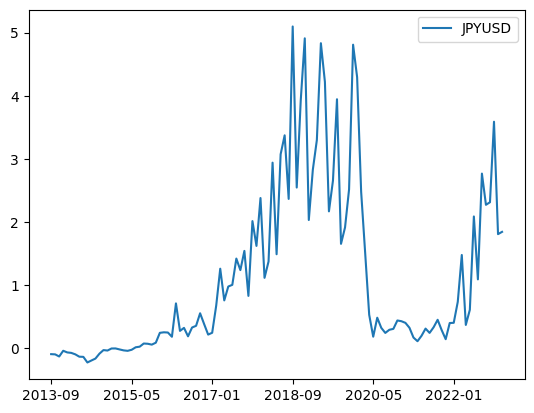

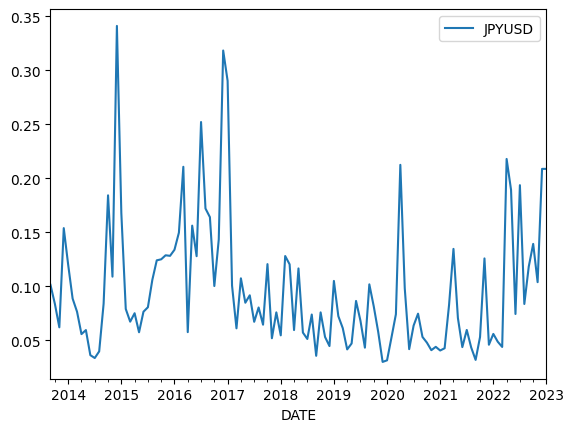

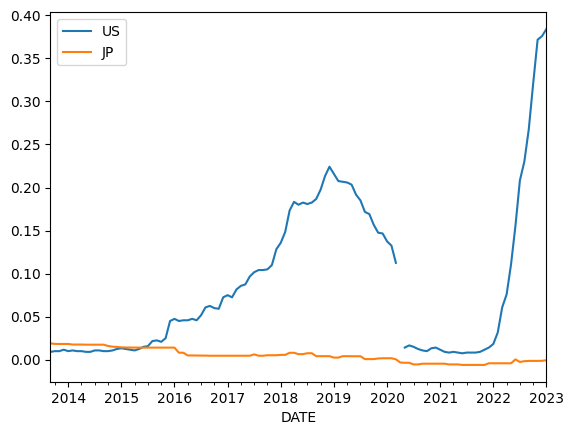

In [ ]:
mtop_5_currency = ["JPYUSD",]
interest_plot = ["US", "JP"]
carry_risk.loc[:,top_5_currency].plot()
monthly_vol.loc[:,top_5_currency].plot()
interest.loc[:,interest_plot].plot()


In [ ]:
SP = price = yf.download("^GSPC", start="2013-01-01", end="2023-01-01", progress=False, ignore_tz="Any")['Close']

display(SP)

Date
2013-01-02    1462.420044
2013-01-03    1459.369995
2013-01-04    1466.469971
2013-01-07    1461.890015
2013-01-08    1457.150024
                 ...     
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
2022-12-30    3839.500000
Name: Close, Length: 2518, dtype: float64